In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fasttext

In [2]:
df = pd.read_csv("cleaned_songs_incl_sentiment.csv")
all_songs = pd.read_csv("all_songs_20_incl_sentiment.csv")

In [80]:
for col in df.columns:
    print(col)

Unnamed: 0
Year
Rank
Song Title
Artist
Primary Artists
Lyrics
Song URL
Song id
Song stats
Song annotations
Tokenized Lyrics
Cleaned Lyrics
Bad Words
Cleaned Lyrics List
Lemmatizated lyrics
n_characters
sentiment_scores_valence
sentiment_scores_vader
lang


# Detect Language

In [ ]:
model = fasttext.load_model('lid.176.ftz')

predicted_lang = model.predict(df["Cleaned Lyrics"].values.tolist(), k=1)[0]
lang_codes = [lang[0][-2:] for lang in predicted_lang]

df["lang"] = lang_codes

# Sentiment Analysis

In [15]:
#NRC Valence, Arousal, and Dominance Lexicon
#https://saifmohammad.com/WebDocs/Lexicons/NRC-VAD-Lexicon.zip
valences=pd.read_csv('valence-NRC-VAD-Lexicon.txt', sep="\t", names=["word", "sentiment_score"])

#VADER
#https://medium.com/@piocalderon/vader-sentiment-analysis-explained-f1c4f9101cd9
#https://www.kaggle.com/datasets/nltkdata/vader-lexicon?resource=download
vader_lexicon=pd.read_csv('vader_lexicon.txt', sep="\t", names=["word", "sentiment_score_wrong_scale", "_", "__"])
vader_lexicon["sentiment_score"]=[(score+4)/8 for score in vader_lexicon["sentiment_score_wrong_scale"]]

In [52]:
# modifiers that change the sentiment of a word
NEGATING_WORDS=["no", "not", "neither", "nor"]

def feature_extraction(df2):
    """
    calculates the features of data in place

    Parameters
    ----------
    data : pd.Dataframe
        data to calculate the features for.
    """
    print([len(df2["Lyrics"][i]) for i in range(len(df2["Lyrics"]))])
    df2["n_characters"] = [len(df2["Lyrics"][i]) for i in range(len(df2["Lyrics"]))]
    
    df2["sentiment_scores_valence"]=get_average_sentiment_scores_for_different_lexicons(df2["Tokenized Lyrics"], valences)
    df2["sentiment_scores_vader"]=get_average_sentiment_scores_for_different_lexicons(df2["Tokenized Lyrics"], vader_lexicon)



def get_average_sentiment_scores_for_different_lexicons(tokens, sent_lexicon):
    """
    calculates the average sentiment score of the tokens according to the provided sentiment lexicon

    Parameters
    ----------
    tokens : list of list of strings
        list of the tokens to calculate the average sentiment for.
    sent_lexicon : pd.Dataframe
        contains a single token (column "word") and a sentiment score (column "sentiment_score") per row.

    Returns
    -------
    average_valences : list of float
        the average sentiment score of the tokens.

    """
    average_sentiment_scores = []
    # one sequence in tokens is equivallent to cell in the dataframe
    for seq in tokens:
        seq = seq.split()
        print(seq)
        
        n_words_with_sentiment_score = 0
        sum_sentiment_scores=0
        
        # first token doesn't have predessors
        # important for negating words
        predecessor = ""
        prepredecessor = ""
        
        for index, token in enumerate(seq):
            # get the fitting row in the sent_lexicon
            row = sent_lexicon.loc[sent_lexicon['word'] == token]
            if len(row) > 0:
                # print(token)
                n_words_with_sentiment_score += 1
                word_sentiment_score = row.iloc[0].sentiment_score
                # print(word_sentiment_score)
                # negating words change the valence of the following words
                if predecessor in NEGATING_WORDS or prepredecessor in NEGATING_WORDS:
                    # 1-x calculates the oposite on a scale from 0 to 1
                    word_sentiment_score = 1-word_sentiment_score
                sum_sentiment_scores += word_sentiment_score
                
            prepredecessor = predecessor
            predecessor = token
        
        if n_words_with_sentiment_score > 0:
            average_sentiment_score = sum_sentiment_scores / n_words_with_sentiment_score
            print(n_words_with_sentiment_score)
        else:
            # if no word was found in the lexicon, the sentence has a neutral sentiment in total
            average_sentiment_score = 0.5
        
        average_sentiment_scores.append(average_sentiment_score)
    return average_sentiment_scores

In [ ]:
# extract the features of lyrics
feature_extraction(df)

In [55]:
df.to_csv("cleaned_songs_incl_sentiment.csv")

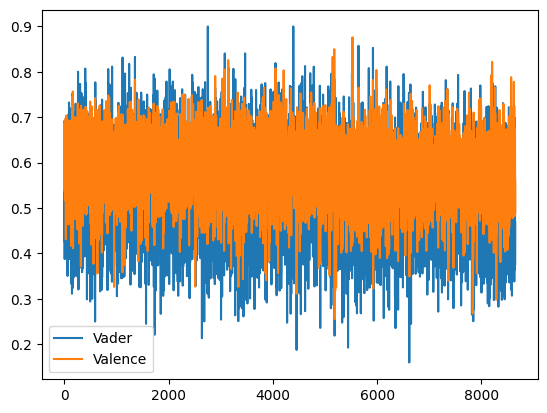

In [54]:
# df2.head

# for column in df2.columns:
#     print(column)

plt.plot(df["sentiment_scores_vader"], label = "Vader")
plt.plot(df["sentiment_scores_valence"], label = "Valence")
plt.legend()
plt.show()

In [83]:
df[df["lang"] == "en"].nlargest(10, 'sentiment_scores_vader')

Unnamed: 0  Year  Rank             Song Title  \
4392        4392  2014    87            Prayer In C   
5642        5642  2018    98                El Bano   
5920        5920  2018    44       Summertime Magic   
3468        3468  2012    91           Time Is Love   
3078        3078  2011    65       Isn't She Lovely   
1356        1356  2007    78          Not Fade Away   
1118        1118  2006    98              Sexy Love   
4050        4050  2013    80           Who You Love   
1244        1244  2006    99                Tu Amor   
4617        4617  2015    60  How Deep Is Your Love   

                                    Artist  \
4392              Lillywood & Robin Schulz   
5642  Enrique Iglesias Featuring Bad Bunny   
5920                      Childish Gambino   
3468                           Josh Turner   
3078                             Glee Cast   
1356                           Sheryl Crow   
1118                                 Ne-Yo   
4050       John Mayer Featuring Katy Perry   
1244                                   RBD   
4617             Calvin Harris & Disciples   

                                        Primary Artists  \
4392                                    Kiesza, 0 songs   
5642  Genius Hebrew Translations (תרגום לעברית), 0 s...   
5920                          Childish Gambino, 0 songs   
3468                               Josh Turner, 0 songs   
3078                                 Glee Cast, 0 songs   
1356                               Sheryl Crow, 0 songs   
1118                                     Ne-Yo, 0 songs   
4050                                John Mayer, 0 songs   
1244                                       RBD, 0 songs   
4617                 Calvin Harris & Disciples, 0 songs   

                                                 Lyrics  \
4392  "Heart-Shaped Box" - Nirvana  "Prayer In A C" ...   
5642   (One Love, One Love) כשראיתי אותך זה עצר הלב ...   
5920   You feel like summertime You took this heart ...   
3468   I know I gotta put in the hours Make the mone...   
3078   Isn't she lovely? Isn't she wonderful? Isn't ...   
1356  LyricsI'm gonna tell you how it's gonna be You...   
1118   My sexy love So sexy   She makes the hairs on...   
4050   You love, who you love Who you love You love,...   
1244   Mi amor, I'm not sure of the right words to s...   
4617   Ah-ooh, ooh, ah-ooh   I want you to breathe m...   

                                               Song URL    Song id  \
4392       https://genius.com/Kiesza-song-covers-lyrics   545564.0   
5642  https://genius.com/Genius-hebrew-translations-...  7229919.0   
5920  https://genius.com/Childish-gambino-summertime...  3831975.0   
3468  https://genius.com/Josh-turner-time-is-love-ly...   445701.0   
3078  https://genius.com/Glee-cast-isnt-she-lovely-l...  1567287.0   
1356  https://genius.com/Sheryl-crow-not-fade-away-l...  1094425.0   
1118          https://genius.com/Ne-yo-sexy-love-lyrics   141996.0   
4050  https://genius.com/John-mayer-who-you-love-lyrics   203995.0   
1244              https://genius.com/Rbd-tu-amor-lyrics   395202.0   
4617  https://genius.com/Calvin-harris-and-disciples...  2158086.0   

                                           Song stats  \
4392             Stats('unreviewed_annotations, hot')   
5642             Stats('unreviewed_annotations, hot')   
5920  Stats('unreviewed_annotations, hot, pageviews')   
3468             Stats('unreviewed_annotations, hot')   
3078             Stats('unreviewed_annotations, hot')   
1356             Stats('unreviewed_annotations, hot')   
1118  Stats('unreviewed_annotations, hot, pageviews')   
4050  Stats('unreviewed_annotations, hot, pageviews')   
1244             Stats('unreviewed_annotations, hot')   
4617  Stats('unreviewed_annotations, hot, pageviews')   

                                       Song annotations  \
4392  [('“Nobody To Love” - Sigma / “Doo Wop (That T...   
5642                                                 []   
5920  [('Got me b

In [82]:
df2 = df[df["lang"] == "en"].nlargest(10, 'sentiment_scores_valence')
df2

Unnamed: 0  Year  Rank                 Song Title  \
5527        5527  2017    85                        DNA   
3144        3144  2011    72  Love You Like A Love Song   
4050        4050  2013    80               Who You Love   
3078        3078  2011    65           Isn't She Lovely   
5986        5986  2018    99              Pete Davidson   
4207        4207  2014    47            Pills N Potions   
3147        3147  2011    97                 So In Love   
8184        8184  2022    12            Love You Better   
2894        2894  2010    59          Welcome Christmas   
3033        3033  2011    91                      Hello   

                                     Artist  \
5527                                    BTS   
3144               Selena Gomez & The Scene   
4050        John Mayer Featuring Katy Perry   
3078                              Glee Cast   
5986                          Ariana Grande   
4207                            Nicki Minaj   
3147  Jill Scott Featuring Anthony Hamilton   
8184                                 Future   
2894                              Glee Cast   
3033            Martin Solveig & Dragonette   

                           Primary Artists  \
5527                          BTS, 0 songs   
3144     Selena Gomez & The Scene, 0 songs   
4050                   John Mayer, 0 songs   
3078                    Glee Cast, 0 songs   
5986                Ariana Grande, 0 songs   
4207                  Nicki Minaj, 0 songs   
3147                   Jill Scott, 0 songs   
8184                       Future, 0 songs   
2894                    Glee Cast, 0 songs   
3033  Martin Solveig & Dragonette, 0 songs   

                                                 Lyrics  \
5527     첫눈에 널 알아보게 됐어 (Hmm-mm) 서롤 불러왔던 것처럼 (Ooh, oo...   
3144   (Rock Mafia)   It's been said and done Every ...   
4050   You love, who you love Who you love You love,...   
3078   Isn't she lovely? Isn't she wonderful? Isn't ...   
5986   Mmm, yeah, yuh   I thought you into my life (...   
4207   Pills and potions We're overdosin' I'm angry,...   
3147   I'm glad this week is over I need to get away...   
8184   Could this thing be more? You can never— this...   
2894   Oooh, ahhh... Fahoo fores, dahoo dores Welcom...   
3033   Hey Hey Hey Hey   I could stick around and ge...   

                                               Song URL    Song id  \
5527                  https://genius.com/Bts-dna-lyrics  3233281.0   
3144  https://genius.com/Selena-gomez-and-the-scene-...    75007.0   
4050  https://genius.com/John-mayer-who-you-love-lyrics   203995.0   
3078  https://genius.com/Glee-cast-isnt-she-lovely-l...  1567287.0   
5986  https://genius.com/Ariana-grande-pete-davidson...  3788156.0   
4207  https://genius.com/Nicki-minaj-pills-n-potions...   433309.0   
3147    https://genius.com/Jill-scott-so-in-love-lyrics  1533964.0   
8184   https://genius.com/Future-love-you-better-lyrics  7945039.0   
2894  https://genius.com/Glee-cast-welcome-christmas...   999805.0   
3033  https://genius.com/Martin-solveig-and-dragonet...   512262.0   

                                           Song stats  \
5527  Stats('unreviewed_annotations, hot, pageviews')   
3144  Stats('unreviewed_annotations, hot, pageviews')   
4050  Stats('unreviewed_annotations, hot, pageviews')   
3078             Stats('unreviewed_annotations, hot')   
5986  Stats('unreviewed_annotations, hot, pageviews')   
4207  Stats('unreviewed_annotations, hot, pageviews')   
3147  Stats('unreviewed_annotations, hot, pageviews')   
8184  Stats('unreviewed_annotations, hot, pageviews')   
2894             Stats('unreviewed_annotations, hot')   
3033  Stats('unreviewed_annotations, hot, pageviews')   

                                       Song annotations  \
5527  [('우리 만남은 (만남은)\n 수학의 공식 (수학의 공식)\n 종교의 율법 (율법...   
3144  [('(Rock Mafia)', [['Rock Mafia is the duo tha...   
4050  [('But you should see him when he shines\n You...   
3078                                          

# Analysis

In [18]:
song_titles = all_songs["Song Title"].values

def get_sentiment_score(song_titles, column):
    sentiment_scores= []
    for title in song_titles:
        score = df[df["Song Title"] == title][column]
        if len(score) == 0:
            score = None
        else:
            score = score.iloc[0]
        
        sentiment_scores.append(score)

    return sentiment_scores

print(song_titles[:5])

all_songs["Valence_Score"] = get_sentiment_score(song_titles, "sentiment_scores_valence")
print("valence finished")
all_songs["Vader_Score"] = get_sentiment_score(song_titles, "sentiment_scores_vader")


['All I Have' 'In Da Club' 'Mesmerize' 'Bump, Bump, Bump' 'Cry Me A River']
valence finished


In [26]:
# all_songs['Vader_Score'].value_counts(bins=10)
print(np.sum(all_songs["Vader_Score"].count()))
print(len(all_songs))

98090
104300


In [20]:
all_songs.to_csv("all_songs_20_incl_sentiment.csv", index=False)

# Getting Map of Artists

In [3]:
import requests
from SPARQLWrapper import SPARQLWrapper, JSON, SPARQLExceptions

user_agent = "experimental code"
sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)


def get_SPARQL_results(query):
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        result = sparql.query()
        
        if result.response.status == 200:
            return result.convert()
        else:
            print(result.response.msg)

    except:
        print(query)
        return None

In [9]:
import wikipedia

artists = all_songs["Artist"].unique()

print((artists))

wikipedia_search_terms = {}
for artist in artists:
    if "featuring" in artist.lower():
        search_term = artist.lower().split("featuring")[0]
    else:
        search_term = artist
    try:
        search_result = wikipedia.search(search_term)[0]
    except:
        search_result = None
    wikipedia_search_terms[artist] = search_result

search_terms = [wikipedia_search_terms[artist] for artist in all_songs["Artist"].values]

['Jennifer Lopez Featuring LL Cool J' '50 Cent'
 'Ja Rule Featuring Ashanti' ... 'Zach Bryan Featuring Maggie Rogers'
 'Junior H X Oscar Maydon' 'Ozuna Featuring Feid']


In [46]:
all_songs["Artist Search Term"] = search_terms
all_songs.to_csv("all_songs_20_incl_sentiment.csv", index=False)

In [ ]:
distinct_artists = all_songs["Artist Search Term"].unique()
print(distinct_artists)

query_with_placeholder = """
        SELECT distinct ?item ?itemLabel ?city ?coord WHERE{  
        ?item ?label "SEARCH_TERM"@en.  
        ?item wdt:P19 ?city.
        ?city wdt:P625 ?coord .
        SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }    
        }
    """

birth_locs = {}

for search_term in distinct_artists:
    query = query_with_placeholder.replace("SEARCH_TERM", str(search_term))

    result = get_SPARQL_results(query)

    try:
        birth_loc = result["results"]["bindings"][0]["coord"]["value"].replace("Point(", "").replace(")", "")
        long, lat = birth_loc.split(" ")
        long = long.strip()
        
        birth_locs[search_term] = (long, lat)
    except Exception as e:
        print(e)
        birth_locs[search_term] = (None, None)


In [8]:
birth_locations = [birth_locs[artist] for artist in all_songs["Artist Search Term"].values]

longs = [birth_locs[artist][0] for artist in all_songs["Artist Search Term"].values]
lats = [birth_locs[artist][1] for artist in all_songs["Artist Search Term"].values]

print(longs)
print(lats)

# all_songs["Birth Location"] = birth_locations
all_songs["birth_long"] = longs
all_songs["birth_lat"] = lats
all_songs.to_csv("all_songs_20_incl_sentiment.csv", index=False)

['-73.873207', '-73.873207', '-73.762486111', None, '-89.971111111', '-77.383333333', '-74.144838888', '-87.95', '-76.29827', None, '-83.012986111', '-87.65005', '16.3725', '-81.103888888', '-97.733333333', '-73.873207', None, '-94.846638888', '-39.315', '-118.24368', None, '-73.2', None, None, None, '-84.8711', '-73.561666666', '-96.668333333', '-94.846638888', '-96.808888888', '-76.29827', None, None, '-73.941666666', '16.3725', None, '-118.009722222', None, '-111.380277777', '-77.036666666', '-73.990277777', None, '-74.444444444', '-118.195555555', '-122.080833333', '-94.141388888', '-75.163611111', None, '-73.873207', '-90.125', '-71.70605', None, '-73.941111111', None, None, '-2.149444444', '-80.754166666', None, None, None, None, None, '-73.917777777', '-77.036666666', '-83.95', '-76.65', '-73.93', None, None, '-84.390277777', '-81.103888888', None, '-83.03526', None, '-87.65005', None, '-2.733611111', '-75.163611111', '-117.946111111', '-73.990277777', '-82.878055555', '-84.3902

## Display on a Map

In [13]:
import plotly.express as px

all_songs = pd.read_csv("all_songs_20_incl_sentiment.csv")

all_songs.dropna(
    axis=0,
    how='any',
    subset=None,
    inplace=True
)

fig = px.scatter_mapbox(all_songs, 
                        lat="birth_lat", 
                        lon="birth_long", 
                        labels="Artist",
                        hover_name="Artist Search Term",
                        zoom=0, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()